In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
THRESHOLD = 0.6
NUM_ITERS = 1000

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)


In [2]:
INPUT_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\input'
OUTPUT_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\output'
POINT_MAPS_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\point_maps'
FRAMES_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\frames'

In [3]:
def drawInliersOutliers(image, point_map, inliers):
    """
    inliers: set of (x1, y1) points
    """
    rows, cols = image.shape
    retImage = np.zeros((rows, cols, 3), dtype='uint8')
    retImage[:, :, :] = np.dstack([image] * 3)

    # Draw circles on top of the lines
    for x1, y1, x2, y2 in point_map:
        point = (int(x1), int(y1))
        color = GREEN if (x1, y1, x2, y2) in inliers else RED
        cv2.circle(retImage, point, 4, color, 1)

    return retImage

In [4]:
def drawMatches(image1, image2, point_map, inliers=None, max_points=1000):
    """
    inliers: set of (x1, y1) points
    """
    rows1, cols1 = image1.shape
    rows2, cols2 = image2.shape

    matchImage = np.zeros((max(rows1, rows2), cols1 + cols2, 3), dtype='uint8')
    matchImage[:rows1, :cols1, :] = np.dstack([image1] * 3)
    matchImage[:rows2, cols1:cols1 + cols2, :] = np.dstack([image2] * 3)

    small_point_map = [point_map[i] for i in np.random.choice(len(point_map), max_points)]

    # draw lines
    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        color = BLUE if inliers is None else (
            GREEN if (x1, y1, x2, y2) in inliers else RED)

        cv2.line(matchImage, point1, point2, color, 1)

    # Draw circles on top of the lines
    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        cv2.circle(matchImage, point1, 5, BLUE, 1)
        cv2.circle(matchImage, point2, 5, BLUE, 1)

    return matchImage

In [5]:
def computeHomography(pairs):
    
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H

In [6]:
def dist(pair, H):
    
    # points in homogeneous coordinates
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate

    return np.linalg.norm(np.transpose(p2) - p2_estimate)

In [7]:
def RANSAC(point_map, threshold=THRESHOLD, verbose=True):
    
    if verbose:
        print(f'Running RANSAC with {len(point_map)} points...')
    bestInliers = set()
    homography = None
    for i in range(NUM_ITERS):
        # randomly choose 4 points from the matrix to compute the homography
        pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]

        H = computeHomography(pairs)
        inliers = {(c[0], c[1], c[2], c[3])
                   for c in point_map if dist(c, H) < 500}

        if verbose:
            print(f'\x1b[2K\r└──> iteration {i + 1}/{NUM_ITERS} ' +
                  f'\t{len(inliers)} inlier' + ('s ' if len(inliers) != 1 else ' ') +
                  f'\tbest: {len(bestInliers)}', end='')

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map) * threshold):
                break

    if verbose:
        print(f'\nNum matches: {len(point_map)}')
        print(f'Num inliers: {len(bestInliers)}')
        print(f'Min inliers: {len(point_map) * threshold}')

    return homography, bestInliers

In [8]:
def createPointMap(image1, image2, verbose=True):
   
    if verbose:
        print('Finding keypoints and descriptors for both images...')
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    cv2.imwrite(OUTPUT_PATH + 'new_keypoints_1.png',
                cv2.drawKeypoints(image1, kp1, image1))
    cv2.imwrite(OUTPUT_PATH + 'new_keypoints_2.png',
                cv2.drawKeypoints(image2, kp2, image2))

    if verbose:
        print('Determining matches...')
    matches = cv2.BFMatcher(cv2.NORM_L2, True).match(desc1, desc2)

    point_map = np.array([
        [kp1[match.queryIdx].pt[0],
         kp1[match.queryIdx].pt[1],
         kp2[match.trainIdx].pt[0],
         kp2[match.trainIdx].pt[1]] for match in matches
    ])

    cv2.imwrite(OUTPUT_PATH + 'new_matches.png',
                drawMatches(image1, image2, point_map))

    with open(f'{POINT_MAPS_PATH}/anuj_point_map.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['x1', 'y1', 'x2', 'y2'])
        for line in point_map:
            writer.writerow(line)

    return point_map

In [9]:
def main(image1, image2, verbose=True):
   
    point_map = None
   
    if verbose:
        print('Creating point map...')
    point_map = createPointMap(image1, image2, verbose=verbose)

    homography, inliers = RANSAC(point_map, verbose=verbose)

    cv2.imwrite(OUTPUT_PATH + 'new_inlier_matches.png',
                drawMatches(image1, image2, point_map, inliers))

    with open(OUTPUT_PATH + 'anuj_outputinfo.txt', 'w') as f:
        f.write(f'Homography:\n{str(homography)}\n\n')
        f.write(f'Num inliers: {len(inliers)}')

    return point_map, inliers, homography

In [10]:
image1 = cv2.imread(INPUT_PATH + r'\Angled\AngledPears.jpg', 0)
image2 = cv2.imread(INPUT_PATH + r'\Straight\StraightPears.jpg', 0)

In [11]:
print("Shape of image1:", image1.shape if image1 is not None else "None")
print("Shape of image2:", image2.shape if image2 is not None else "None")

Shape of image1: (4032, 3024)
Shape of image2: (4032, 3024)


In [12]:
if image1 is None or image2 is None:
    print("Error while Loading images")
else:
    print("Images Loaded successfully")

Images Loaded successfully


In [13]:
point_map, inliers, homography = main(image1,image2)

Creating point map...
Finding keypoints and descriptors for both images...
Determining matches...
Running RANSAC with 2028 points...
└──> iteration 1000/1000 	220 inliers 	best: 790[2K2K
Num matches: 2028
Num inliers: 790
Min inliers: 1216.8


In [14]:
print("Computed Homography Matrix:\n", homography)

# Saving the homography matrix 
np.save('anuj_homography_matrix_left.npy', homography) 

Computed Homography Matrix:
 [[ 1.79992375e+00 -1.04036779e-01 -6.80101546e+02]
 [-2.95446075e-02  1.05401206e+00 -2.06319793e+01]
 [ 1.37134870e-04 -2.98294444e-05  1.00000000e+00]]


In [15]:
# homography_matrix_path = 'homography_matrix.npy'
# homography_anuj = np.load(homography_matrix_path)

In [16]:
im_dst=cv2.warpPerspective(image1,homography,(image1.shape[1],image1.shape[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Anuj Bohra\\Desktop\\IIT_Patna\\anujwarp\\warpedImages\\warped_image_bhujia.png'

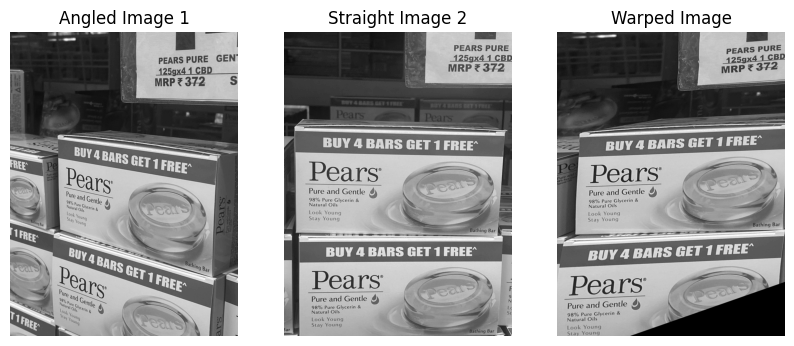

In [17]:
import os
import matplotlib.pyplot as plt

# Define the output directory
output_directory = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\warpedImages' 

# File name for the saved figure
output_file = os.path.join(output_directory, 'warped_image_bhujia.png')

# Generate and display the images
plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(image1, cmap='gray'), plt.title('Angled Image 1'), plt.axis('off')
plt.subplot(132), plt.imshow(image2, cmap='gray'), plt.title('Straight Image 2'), plt.axis('off')
plt.subplot(133), plt.imshow(im_dst, cmap='gray'), plt.title('Warped Image'), plt.axis('off')

# Save the figure
plt.savefig(output_file, bbox_inches='tight')
plt.show()

print(f"Image saved to {output_file}")

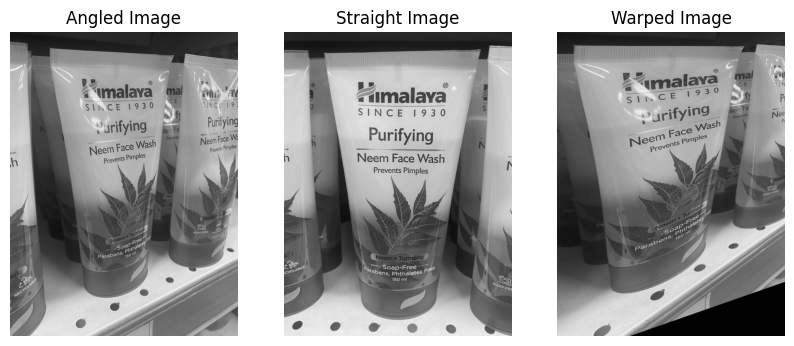

Image saved to C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\warpedImagesCoffeeMatrix(left)\warped_image_facewasht_new.png


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the previously saved homography matrix
homography_matrix_path = 'anuj_homography_matrix_left.npy'
homography_anuj = np.load(homography_matrix_path)

def warp_image(image, homography_anuj):
    """
    Apply the homography matrix to warp the input image.
    """
    warped_image = cv2.warpPerspective(image, homography_anuj, (image.shape[1], image.shape[0]))
    return warped_image

def main():
    new_image_angled = cv2.imread(INPUT_PATH + r'\Angled\A_Facewash.jpg', 0)  # Load as grayscale
    new_image_straight = cv2.imread(INPUT_PATH + r'\Straight\S_FacewashHimalaya.jpg', 0)

    if new_image_angled is None:
        print(f"Error: Unable to load image at {new_image_angled}")
        return None, None

    # Warp the new image using the homography matrix
    warped_image = warp_image(new_image_angled, homography_anuj)

    return new_image_angled, new_image_straight, warped_image

if __name__ == "__main__":
    INPUT_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\input'
    
    # Call the main function
    new_image_angled, new_image_straight, warped_image = main()

    if new_image_angled is not None and new_image_straight is not None and warped_image is not None:
        # Define the output directory
        output_directory = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\anujwarp\warpedImagesCoffeeMatrix(left)'

        # File name for the saved figure
        output_file = os.path.join(output_directory, 'warped_image_facewasht_new.png')

        # Generate and display the images
        plt.figure(figsize=(10, 5))
        plt.subplot(131), plt.imshow(new_image_angled, cmap='gray'), plt.title('Angled Image'), plt.axis('off')
        plt.subplot(132), plt.imshow(new_image_straight, cmap='gray'), plt.title('Straight Image'), plt.axis('off')
        plt.subplot(133), plt.imshow(warped_image, cmap='gray'), plt.title('Warped Image'), plt.axis('off')

        # Save the figure
        plt.savefig(output_file, bbox_inches='tight')
        plt.show()

        print(f"Image saved to {output_file}")
    else:
        print("Error: One or more images were not loaded correctly.")
